# Autoencoders

*Tutors*:
-- Federico Milanesio: federico.milanesio@unito.it
-- Davide Pirovano: davide.pirovano@unito.it

<div>
<img src="https://imgs.xkcd.com/comics/ai_hiring_algorithm.png" width="550"/>
</div>

In [ ]:
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import torchvision.transforms as transforms
import torchvision

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


# Setting up an autoencoder

We will use MNIST as our dataset. Note that we do not normalize our output given that they are already normalized in the range $[0,1]$, making additional normalization less critical. In the case of autoencoders, the primary goal is to **learn a representation (encoding) of the input data** that can accurately reconstruct the original input. The effectiveness of an autoencoder relies more on the architecture of the model and the optimization process rather than the preprocessing of input data. Still, this needs to be evaluated on a case-by-case basis

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),                              # <-- we dont normalize here, can you guess why based on the rest of the notebook?
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


We now define our model. A few notes:


1.   We use linear layers for simplicity, but you can use any type of layer you want
2.   Encoder and decoder **do not share weights** in our network. Sharing weights between the encoder and decoder can reduce the total number of model parameters, which may lead to simpler models and reduced risk of overfitting, especially when training data is limited. But tied weights restrict the flexibility of the model, potentially limiting its ability to capture complex relationships between input and output. Whether to share weights between encoder and decoder is a choice that is based on **Task Complexity** and the application of you network
3. At the end we use a sigmoid forces the output to the range $[0, 1]$, interpreted as pixel intensity of a grey scale image.



In [ ]:
width = 28

# encoder layers
encoder = nn.Sequential(
  ...
)

# decoder layers
decoder = nn.Sequential(
  ...
)


model = nn.Sequential(
    nn.Flatten(1, 3),
    encoder,
    decoder,
    nn.Sigmoid(),                       # output pixel values in range [0, 1] for grayscale images
    nn.Unflatten(1, (1, width, width))
)

model = model.to(device)

We will use **MSE**, a popular choice for training autoencoders, but other losses can be tried as well, such as Binary Cross Entropy and L1

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),
                       lr=1e-2,
                       weight_decay=1e-6)

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    loss = 0.0
    for x, _ in train_loader:

        x = x.to(device)

        x_pred = model(x)
        loss = criterion(x_pred, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss += loss.item()


    print(f"Epoch {epoch + 1}, Loss: {loss / len(train_loader):.5f}")


Epoch 1, Loss: 0.00014
Epoch 2, Loss: 0.00010
Epoch 3, Loss: 0.00010
Epoch 4, Loss: 0.00008
Epoch 5, Loss: 0.00008


When training autoencoders, often it best to see the result of reconstruction instead of focusing only on the numerical loss of the model

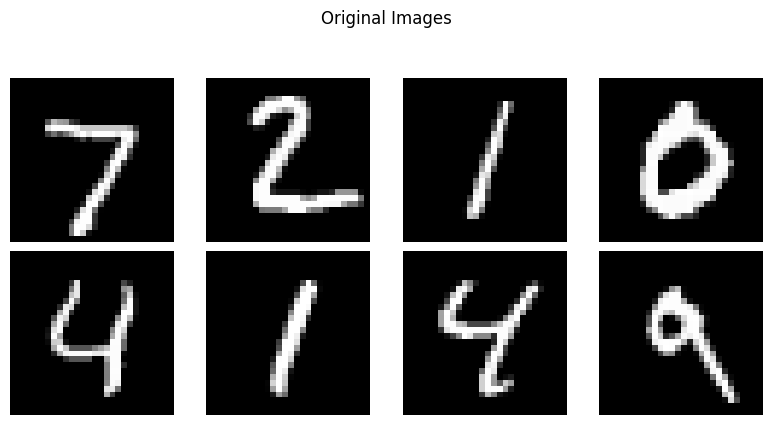

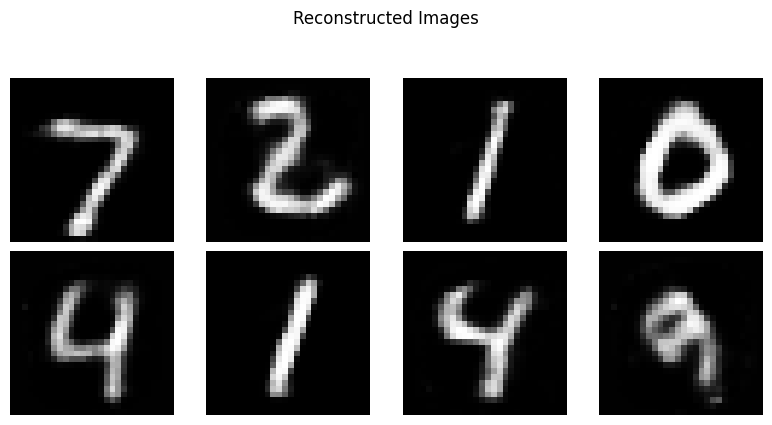

In [ ]:
with torch.no_grad():
    for images, _ in test_loader:
        reconstructed_images = model(images)
        break

def plot_images(images, title):
    plt.figure(figsize=(8, 4))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].squeeze().numpy(), cmap='gray')
        plt.axis('off')
    plt.suptitle(title, y=1.05)
    plt.tight_layout()

# plot original and reconstructed images
plot_images(images, title="Original Images")
plot_images(reconstructed_images, title="Reconstructed Images")

plt.show()

**Exercise 1**: Define the encoder and decoder modules for our autoencoder. Can we improve its performance by **optimizing hyperparameters** and adjusting the model architecture? Additionally, can we include a **visualization of the train and test loss** over the training process to detect signs of overfitting, or alternatively, implement early stopping? Are there **random transformation** we could implement on the training set?

In [ ]:
...

Ellipsis

# Exploring the representations

Now that we have a trained autoencoder, we can **look inside the model** and explore what it has learned. To do this, we will use PCA.

PCA finds the set of $m$ variables as linear combinations of the original variables that explains the most variance. It can be shown that the principal components are eigenvectors of the data's covariance matrix $\frac{1}{n}X^TX$. We will find the first two and plot them to see how well the autoencoder **clusters** similar examples.

In [ ]:
from sklearn.decomposition import PCA

latents = []
labels = []

with torch.no_grad():
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device)
        z = model[0:2](x)
        latents.append(z.cpu())
        labels.append(y)

latents, labels = torch.cat(latents), torch.cat(labels)

In [ ]:
pca = PCA(n_components=2, random_state=42)
latents_2d = pca.fit_transform(latents)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap="tab10", alpha=0.7)
plt.colorbar(scatter, label="digit")
plt.title("pca of latent space")
plt.show()

Now we try to **move through the latent space**?

We'll pick two input images $x_1$, $x_2$, encode them into the latent space $z_1$, $z_2$, and linearly interpolate between them.

$z_{\text{new}}=\alpha z_1 + (1-\alpha)z_2$, $\;\;\;\alpha \in [0,1]$

Then, we'll decode each intermediate point back into an image.

This reveals how the model interprets smooth transitions in the underlying data distribution. Ideally, we should see a gradual morphing from one digit to another.


In [ ]:
steps = 10

(x1, _), (x2, _) = test_dataset[0], test_dataset[1]  # <-- we select two samples from the dataset

z1 = model[0:2](x1.unsqueeze(0).to(device))
z2 = model[0:2](x2.unsqueeze(0).to(device))

interpolated = torch.stack([
        z1 * (1 - alpha) + z2 * alpha
        for alpha in torch.linspace(0, 1, steps)
    ]).squeeze()

with torch.no_grad():
  decoded = model[2:](interpolated).cpu()

fig, axes = plt.subplots(1, steps, figsize=(steps, 1.5))
for i, ax in enumerate(axes):
    ax.imshow(decoded[i][0], cmap="gray")
    ax.axis("off")
plt.suptitle("Latent Space Interpolation")
plt.show()


We can compare the result with blending images by averaging pixels directly (not via the latent space).

In [ ]:
interpolated = torch.stack([
        x1 * (1 - alpha) + x2 * alpha
        for alpha in torch.linspace(0, 1, steps)
    ])

fig, axes = plt.subplots(1, steps, figsize=(steps, 1.5))
for i, ax in enumerate(axes):
    ax.imshow(interpolated[i][0], cmap="gray")
    ax.axis("off")
plt.suptitle("Original Space Interpolation")
plt.show()

# Denoising autoencoders

Let's see how well our autoencoder performs over noisy images, where we added Gaussian noise.

In [ ]:
def add_noise(inputs, noise_factor=0.4):
    noisy = inputs + noise_factor * torch.randn_like(inputs)
    noisy = torch.clamp(noisy, 0., 1.)    # <-- clamps all elements 0 < x < 1
    return noisy

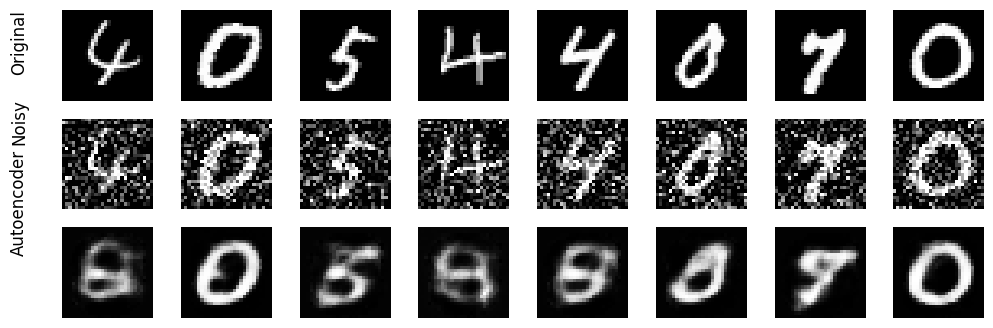

In [ ]:
for x, _ in train_loader:
  x = x[:8].to(device)                 # <-- we select 8 points
  noisy_x = add_noise(x)
  recon = model(noisy_x).detach()
  break

fig, axs = plt.subplots(3, 8, figsize=(8 * 1.5, 4))
for i in range(8):
  axs[0, i].imshow(x[i][0].cpu(), cmap="gray")
  axs[1, i].imshow(noisy_x[i][0].cpu(), cmap="gray")
  axs[2, i].imshow(recon[i][0].cpu(), cmap="gray")
  for row in axs:
    row[i].axis('off')

fig.text(0.1, 0.8, "Original", va='center', ha='right', fontsize=12, rotation='vertical')
fig.text(0.1, 0.6, "Noisy", va='center', ha='right', fontsize=12, rotation='vertical')
fig.text(0.1, 0.4, "Autoencoder", va='center', ha='right', fontsize=12, rotation='vertical')


plt.show()


A **denoising autoencoder** is trained not just to reconstruct its input, but to remove noise from it.

During training, we corrupt the input image (e.g., by adding Gaussian noise), but we still ask the model to reconstruct the original, clean version. This encourages the autoencoder to learn more robust and meaningful representations.

**Exercise 2**: Train a denoising autoencoder on the noisy images. Can it remove noise while preserving the underlying structure?

In [ ]:
denoising_model = ...

In [ ]:
optimizer = ...
num_epochs = 5

for epoch in range(num_epochs):
    loss = 0.0
    for x_train, _ in train_loader:

        x_train = x_train.to(device)

        noisy_x = add_noise(x_train)       # <-- we train on noisy data
        x_pred = denoising_model(noisy_x)

        loss = criterion(x_pred, x_train)  # <-- the loss is computed on the noiseless image

        ...


Let's visualize the performance of the denoising model compared to the original autoencoder.

In [ ]:
for x, _ in train_loader:
  x = x[:8].to(device)                 # <-- we select 8 points
  noisy_x = add_noise(x)
  recon = model(noisy_x).detach()
  denoising_recon = denoising_model(noisy_x).detach()
  break

fig, axs = plt.subplots(4, 8, figsize=(8 * 1, 8))
for i in range(8):
  axs[0, i].imshow(x[i][0].cpu(), cmap="gray")
  axs[1, i].imshow(noisy_x[i][0].cpu(), cmap="gray")
  axs[2, i].imshow(recon[i][0].cpu(), cmap="gray")
  axs[3, i].imshow(denoising_recon[i][0].cpu(), cmap="gray")
  for row in axs:
    row[i].axis('off')

fig.text(0.1, 0.8, "Original", va='center', ha='right', fontsize=12, rotation='vertical')
fig.text(0.1, 0.6, "Noisy", va='center', ha='right', fontsize=12, rotation='vertical')
fig.text(0.1, 0.4, "Autoencoder", va='center', ha='right', fontsize=12, rotation='vertical')
fig.text(0.1, 0.2, "Denoising", va='center', ha='right', fontsize=12, rotation='vertical')

plt.show()

*© 2024. This work is openly licensed via [CC BY-NC-SA 4.0 DEED](https://creativecommons.org/licenses/by-nc-sa/4.0/)*

*Comics used in the notebooks are from [xkcd.com](https://xkcd.com), and are licensed under the Creative Commons Attribution-NonCommercial 2.5 license.*

*Details and usage notes can be found at [xkcd.com/license.html](https://xkcd.com/license.html).*